### 0.0 Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# util
import inflection
from IPython.display import Image
from scipy import stats

### 0.1 Helper Functions

In [1]:
# Just so I can remember their meaning throughtout the analysis
def describe_columns():
    columns_explanation = '''
            RowNumber: Row number\n
            CustomerID: Customer ID\n
            Surname: Surname.\n
            CreditScore: The customer's Credit score for the consumer market.\n
            Geography: The country where the customer lives.\n
            Gender: Gender.\n
            Age: Age.\n
            Tenure: How many years has the customer been a bank customer.\n
            Balance: Monetary value that the customer has in his bank account.\n
            NumOfProducts: The number of products purchased by the customer at the bank.\n
            HasCrCard: Indicates whether the customer has a credit card or not.\n
            IsActiveMember: Indicates whether the customer made at least one transaction in the bank account within 12 months.\n
            EstimateSalary: Estimated Annual Salary.\n
            Exited: Indicates whether the customer is in Churn or not.\n'''
    print(columns_explanation)

    
def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    #display(nan_data_frame)
    return nan_data_frame
    
    

### 0.2 Loading Data

In [4]:
raw_data = pd.read_csv("churn.csv")
raw_data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## 1.0 Describe Data

In [3]:
data = raw_data.copy()

### Columns Dictionary

        RowNumber: Row number
        
        CustomerID: Customer ID
        
        Surname: Surname
        
        CreditScore: The customer's Credit score for the consumer market
        
        Geography: The country where the customer lives
        
        Gender: Gender
        
        Age: Age
        
        Tenure: How many years has the customer been a bank customer
        
        Balance: Monetary value that the customer has in his bank account
        
        NumOfProducts: The number of products purchased by the customer at the bank
        
        HasCrCard: Indicates whether the customer has a credit card or not.
        
        IsActiveMember: Indicates whether the customer made at least one transaction
                        in the bank account within 12 months.
                        
        EstimateSalary: Estimated Annual Salary
        
        Exited: Indicates whether the customer is in Churn or not.




### 1.1 Rename Columns

In [4]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
old_columns = data.columns

# transform snakecase with inflection
snakecase = lambda x: inflection.underscore(x)
new_columns = map(snakecase, old_columns)

data.columns = new_columns
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [10]:
data.to_csv("churn_data.csv", index=False) # I'll use it way later in the web app

> **0 missing values and also no duplicates.** It's a good start.

In [8]:
describe_data(data)

Shape: (10000, 14)
Duplicates: False


,data_types,nan_count,nan_percentage
row_number,int64,0,0.0
customer_id,int64,0,0.0
surname,object,0,0.0
credit_score,int64,0,0.0
geography,object,0,0.0
gender,object,0,0.0
age,int64,0,0.0
tenure,int64,0,0.0
balance,float64,0,0.0
num_of_products,int64,0,0.0


### 1.2 Descriptive Statistical

In [9]:
numerical_attributes = data.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = data.select_dtypes( exclude=['int64', 'float64'] )

#### 1.2.1. Numerical Attributes

From here We already know that
    
> **20% of customers are in churn.**
>
> Half of customers are active members.
>
> 70% has credit card.
> 

    And the minimum salary seems too low (we'll check it out later).
   

In [10]:
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew()), columns=['skew']).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis()), columns=['kurtosis']).T
stats = pd.concat([data.describe(), skew, kurtosis]).T

def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    df.iloc[8, 0] = df.iloc[7, 0] = df.iloc[-1, 0] = 'background-color: lightgreen'
    df.iloc[-2, 2] = 'background-color: red'
    return df

stats.drop(columns='count').style.apply(style_specific_cell, axis=None).format("{:.2f}")

,mean,std,min,25%,50%,75%,max,skew,kurtosis
row_number,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00,0.00,-1.20
customer_id,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00,0.00,-1.20
credit_score,650.53,96.65,350.00,584.00,652.00,718.00,850.00,-0.07,-0.43
age,38.92,10.49,18.00,32.00,37.00,44.00,92.00,1.01,1.40
tenure,5.01,2.89,0.00,3.00,5.00,7.00,10.00,0.01,-1.17
balance,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09,-0.14,-1.49
num_of_products,1.53,0.58,1.00,1.00,1.00,2.00,4.00,0.75,0.58
has_cr_card,0.71,0.46,0.00,0.00,1.00,1.00,1.00,-0.90,-1.19
is_active_member,0.52,0.50,0.00,0.00,1.00,1.00,1.00,-0.06,-2.00
estimated_salary,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48,0.00,-1.18


#### 1.2.2. Categorical Attributes

In [11]:
categorical_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

        So far, boxplots are pretty similar and the one which gets my attention is the "balance" one.
        Even though the salaries among the countries are quite similar, people in Germany, in general,
        has a greater balance account. Does it mean a better financial education? Anyways, it might 
        also mean that by losing a customer from Germany there's a high chance of losing a good customer.

In [12]:
numerical_attributes.columns

Index(['row_number', 'customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

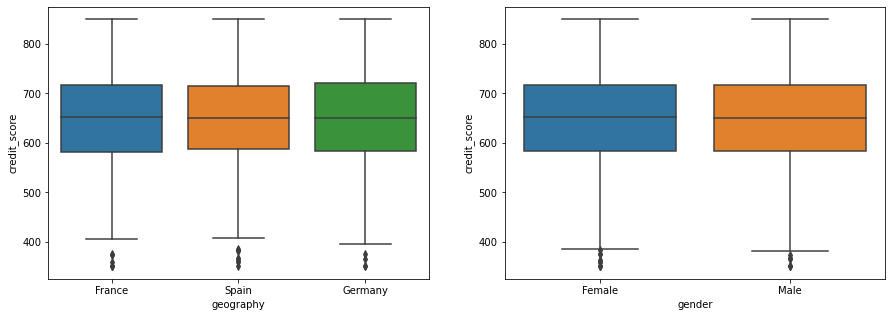

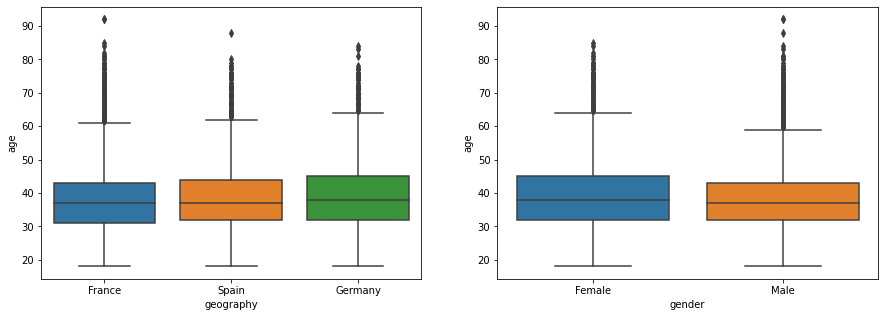

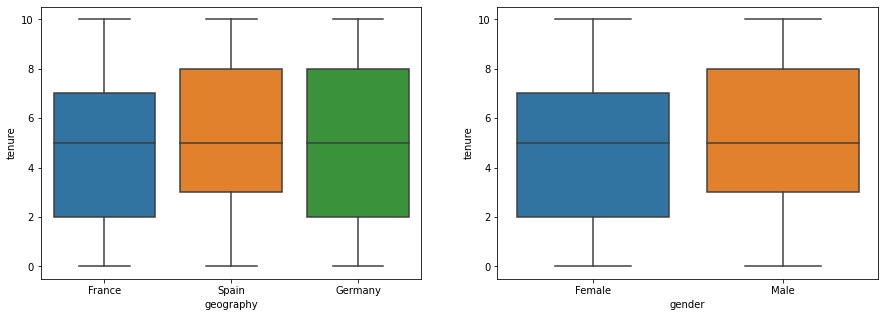

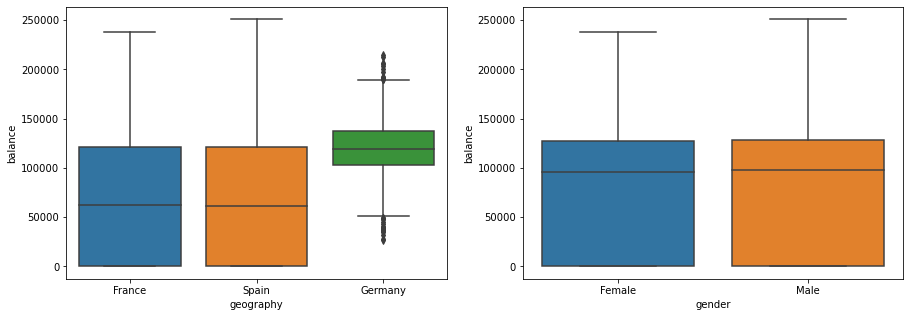

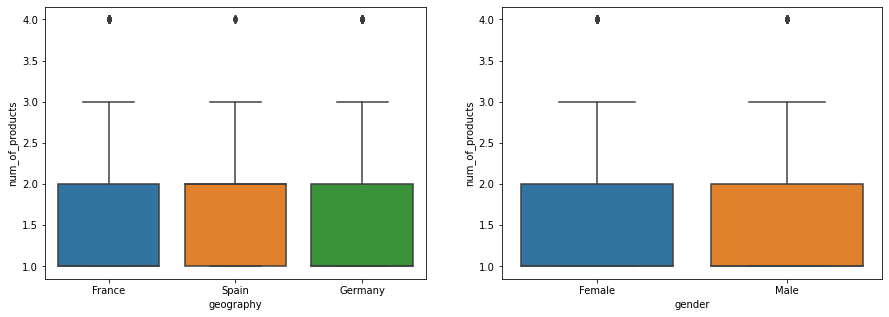

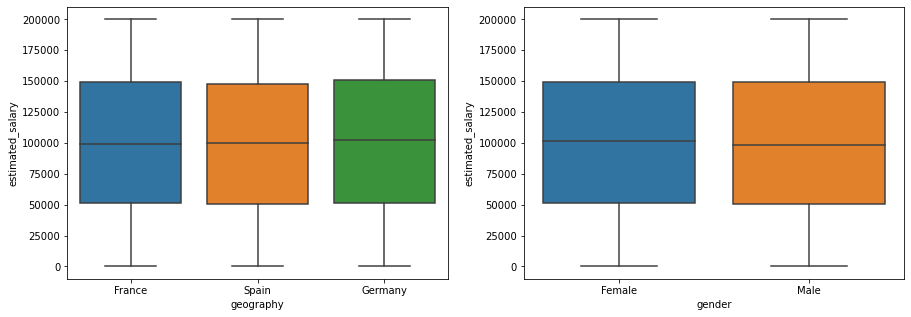

In [13]:
numerical_attributes_list = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

for attribute in numerical_attributes_list:
    plt.figure(figsize=(15,5))
    plt.subplot( 1, 2, 1 )
    sns.boxplot( x='geography', y = attribute, data=data )

    plt.subplot( 1, 2, 2 )
    sns.boxplot( x='gender', y = attribute, data=data )
    
    print("\n\n"); plt.show()

## 2.0 Hypotheses Creation

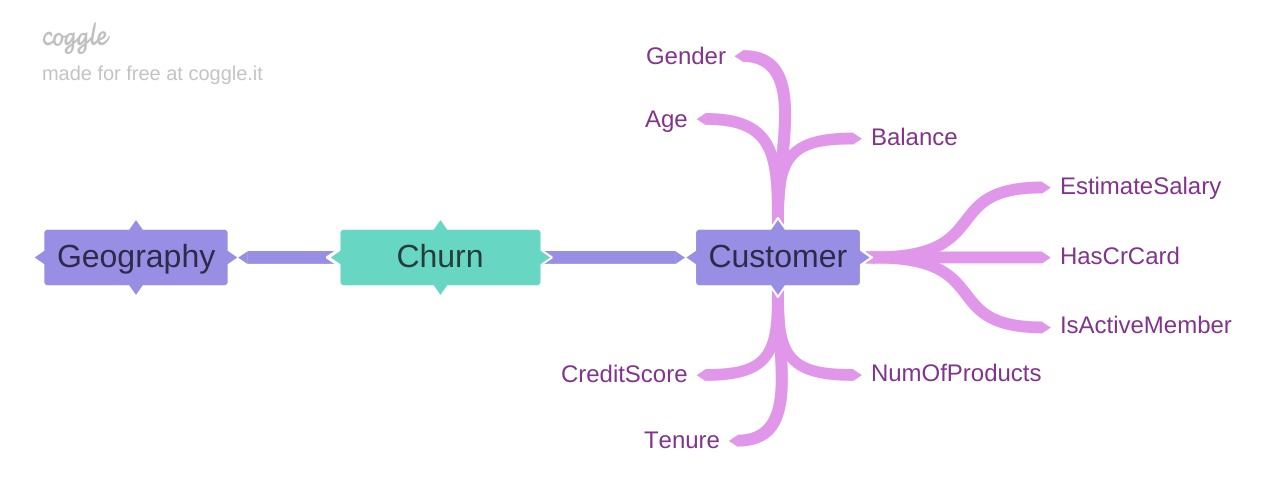

In [13]:
Image( 'hypotheses mind map.png' )

### 2.1 Hypotheses

#### 2.1.1. Customer hypotheses.

**1.** Younger customers have higher churn rate.
        
        Which age brings more revenue?

**2.** Higher balance customers have lower turnover rate.

        Does higher balance mean more revenue?

**3.** Customers with higer salaries have lower churn rate.

        Does higher salary mean more revenue?

**4.** Customers who are active members have lower churn rate.

        How much do we earn from active members?

**5.** Customers who buy more products have lower churn rate.

        Who brings us more revenue from those?

**6.** "Older" customers have lower churn rate.

        The longer the time, greater is the revenue?

**7.** Customers with credit card have a lower churn rate.

        Are they the most responsible for revenue?

**8.** Customers with higher credit score have lower churn rate.

        Does a higher credit score mean more revenue?

#### 2.1.3. Geography hypotheses.

        Which country does the biggest revenue come from?

**1.** Country that has more customers on "active members group" has lower churn rate.

**2.** Country with higher average credit score has lower churn rate.

**3.** Country with higher sum of balances have lower churn rate.

**4.** Country with higher average balance have lower churn rate.

**5.** Country with higher average salary has lower churn rate.

**6.** Country with more credit card customers has lower churn rate.

## 3.0 Feature Engineering

In [14]:
data.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [15]:
# symmetrical distribution - we'll use the mean
print( round(data['estimated_salary'].mean(),2), data['estimated_salary'].median() )

100090.24 100193.915


### 3.1 Annual Revenue

    How much do TopBank expect to gain from this customer? 

**_According to the TopBank Analytics team, each customer who has this bank account returns a monetary value of 15% of the value of their estimated salary, if it is less than the average and 20% if this salary is higher than the average, during the current period of your account. This value is calculated annually._**

Let's calculate the annual revenue, then.

In [16]:
mean_salary = data['estimated_salary'].mean()
TWELVE_MONTHS = 12

data['annual_revenue'] = [(salary/TWELVE_MONTHS)*0.2 if salary > mean_salary else (salary/TWELVE_MONTHS)*0.15 
                           for salary in data['estimated_salary']]

### 3.2 Revenue per Product

    Would it be "How much is this customer paying for each product?"?
    Not quite, but since we don't have this specific data, let's use 
    it as an alternative.

In [17]:
data['revenue_per_product'] = data['annual_revenue'] / data['num_of_products']

### 3.3 Total Revenue

    How much did TopBank earn with this customer until today?

In [18]:
data['total_revenue'] = [tenure*annual_earning if tenure > 0 else annual_earning
                         for tenure, annual_earning in zip(data['tenure'], data['annual_revenue'])]

## 4.0 Filtering The Features

In [19]:
data_frame = data.copy()
data_frame.head(3)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,annual_revenue,revenue_per_product,total_revenue
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1689.148000,1689.148000,3378.296000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1875.709667,1875.709667,1875.709667
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1898.859500,632.953167,15190.876000


### 4.1 Column Selection

    These columns won't be helpful at all. They're too specific,
    We want to generalize so the solution will work for as much
    observations as we'll have.

In [20]:
drop_columns = ['row_number','customer_id','surname']
data_frame.drop(columns=drop_columns, inplace=True)